In [1]:
import scipy
import bagpy
import numpy as np
from bagpy import bagreader
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
from matplotlib import rc
import statistics
rc('text', usetex=False) 


/home/zozan/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
bag = "median_filtered_data.bag"
bag = "first_box_touching_experiment.bag"
bag = "occlusion_exp.bag"
#bag = "unfiltered_data.bag"

b = bagreader(bag)

[INFO]  Data folder occlusion_exp already exists. Not creating.


In [4]:
def get_topics(b):
    csv_files = []
    for topic in b.topics:
        #print(topic)
        data = b.message_by_topic(topic)
        csv_files.append(data)
    return csv_files

csv_files = get_topics(b)
print(csv_files
     )


upper_body_3d = pd.read_csv(csv_files[-1])
right_arm = pd.read_csv(csv_files[-2])
left_arm = pd.read_csv(csv_files[-3])
cart_right_arm = pd.read_csv(csv_files[1])

cart_left_arm = pd.read_csv(csv_files[0])
norm_left_arm = pd.read_csv(csv_files[4])


print(norm_left_arm)

['recorded_data/joint_states.csv', 'recorded_data/position_joint_trajectory_controller-command.csv']


IndexError: list index out of range

In [5]:
csv_files = get_topics(b)

print(csv_files)

def scale_any_time(time):    
    scaled_time = pd.Series([t - time[0] for t in time])    
    return scaled_time

def plot_arm(arm, savename, title="left_arm"): 
    
        
    w, h = 10, 5
    
    plt.figure(figsize=(w, h))
    
    scaled_t = scale_any_time(arm["Time"])
    s_pitch = arm["shoulder_pitch.data"]
    s_roll = arm["shoulder_roll.data"]
    s_yaw = arm["shoulder_yaw.data"]
    e = arm["elbow.data"]

    
    plt.plot(scaled_t, s_pitch, label="s_pitch", linewidth=2)
    #plt.plot(jst, m_pitch, label="m_pitch")
    plt.plot(scaled_t, s_roll, label="s_roll", linewidth=2)
    #plt.plot(jst, m_roll, label="m_roll")
    plt.plot(scaled_t, s_yaw, label="s_yaw", linewidth=2)
    #plt.plot(jst, m_yaw, label="m_yaw")
    plt.plot(scaled_t, e, label="elbow", linewidth=2)
    #plt.plot(jst, m_e, label="elbow")
    
    plt.grid(color="grey")
    plt.title("{}".format(title), fontsize=20)
    plt.xlabel("Time [s]", fontsize=15)
    plt.ylabel("Angle [rad]", fontsize=15)
    plt.legend(loc='best', fontsize=12)
    plt.tight_layout()
    plt.savefig(savename)
    
def plot_position(arm, savename, title): 
    
    w, h = 10, 5
    
    plt.figure(figsize=(w, h))
    t = scale_any_time(arm["Time"])
    
    x = arm["positionEE.x"]
    y = arm["positionEE.y"]
    z = arm["positionEE.z"]

    plt.plot(t, x, label="x")
    plt.plot(t, y, label="y")
    plt.plot(t, z, label="z")
    plt.grid(color="grey")
    plt.title(title, fontsize=20)
    plt.xlabel("Time[s]", fontsize=15)
    plt.ylabel("position [m]", fontsize=15)
    plt.legend(loc="best", fontsize=15)
    plt.tight_layout()
    plt.savefig(savename)
    
def plot_norms(norm, savename, title):
    
    w, h = 10, 5
    
    plt.figure(figsize=(w, h))
    t = scale_any_time(norm["Time"])
    
    sE = norm["shoulderElbow.data"]
    eW = norm["elbowWrist.data"]
    sW = norm["shoulderWrist.data"]

    plt.plot(t, sE, label="sE")
    plt.plot(t, eW, label="eW")
    plt.plot(t, sW, label="sW")
    plt.grid(color="grey")
    plt.title(title, fontsize=20)
    plt.xlabel("Time[s]", fontsize=15)
    plt.ylabel("norm [m]", fontsize=15)
    plt.legend(loc="best", fontsize=15)
    plt.tight_layout()
    plt.savefig(savename)
    
    
    

['occlusion_exp/cart_left_arm.csv', 'occlusion_exp/cart_right_arm.csv', 'occlusion_exp/kalman_cart_right_arm.csv', 'occlusion_exp/left_arm.csv', 'occlusion_exp/norm_left_arm.csv', 'occlusion_exp/norm_right_arm.csv', 'occlusion_exp/right_arm.csv', 'occlusion_exp/upper_body_3d.csv']


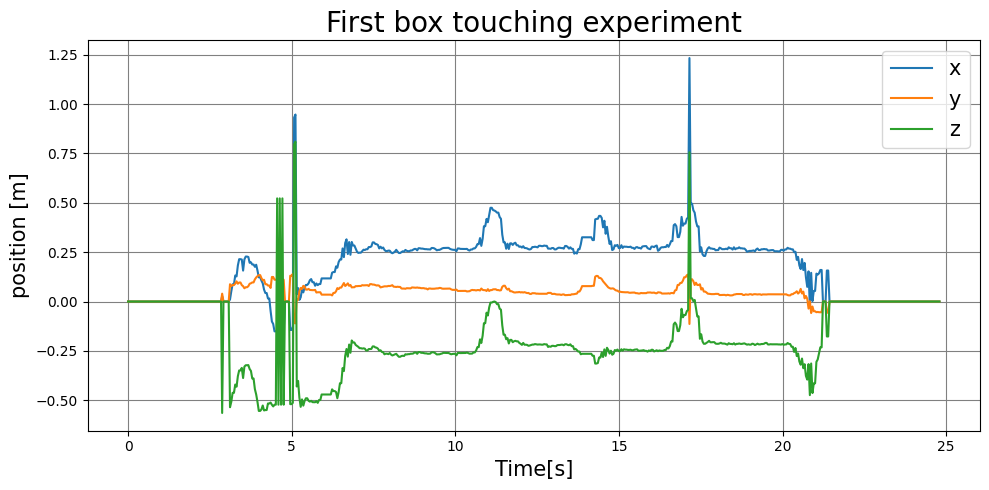

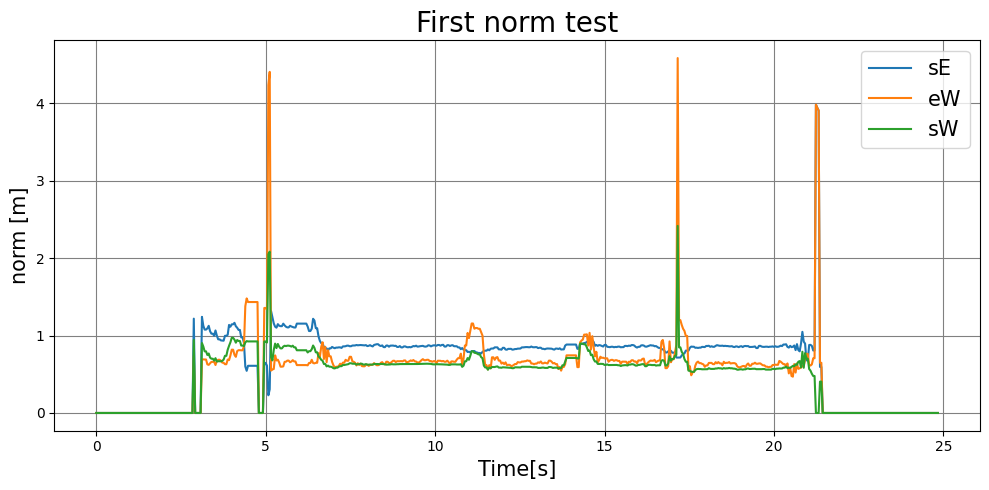

In [6]:
plot_position(cart_left_arm, "Box touching", "First box touching experiment")
plot_norms(norm_left_arm, "Norm", "First norm test")

In [28]:
import time
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

total_len  = len(cart_left_arm['Time'])
start = 200
end = 800
t = scale_any_time(cart_left_arm['Time']).tolist()[start:end]
t = [t_*0.04 for t_ in t]
px = cart_left_arm['positionEE.x'].tolist()[start:end] 
py = cart_left_arm['positionEE.y'].tolist()[start:end] 
pz = cart_left_arm['positionEE.z'].tolist()[start:end] 
vx = cart_left_arm['velocityEE.x'].tolist()[start:end]
vy = cart_left_arm['velocityEE.y'].tolist()[start:end]
vz = cart_left_arm['velocityEE.z'].tolist()[start:end]

m_val = 27
median_px = scipy.signal.medfilt(np.array(px), m_val)
median_py = scipy.signal.medfilt(np.array(py), m_val)
median_pz = scipy.signal.medfilt(np.array(pz), m_val)


In [29]:
def getNextMeas(array, n):
    return array[n]

# Kalman filter 

Used resources are: 
 * [Vehicle location estimation](https://www.kalmanfilter.net/multiExamples.html) 
 

In [30]:
numMeas = len(px)
print("Num meas is: {}".format(numMeas))
kalmanX, kalmanY, kalmanZ = [], [], []
kalmanvX, kalmanvY, kalmanvZ = [], [], []
x_start = px[0]
vx_start = 0
y_start = py[0]
vy_start = 0
z_start = pz[0]
vz_start = 0

f = KalmanFilter (dim_x=6, dim_z=3)

# position vector
f.x = np.array([[x_start],
                [vx_start], 
                [y_start], 
                [vy_start], 
                [z_start], 
                [vz_start]])

# State transition 
f.F = np.array([[1., 0.04, 0., 0.00, 0., 0.00], 
                [0., 1.00, 0., 0.00, 0., 0.00], 
                [0., 0.00, 1., 0.04, 0., 0.00], 
                [0., 0.00, 0., 1.00, 0., 0.00], 
                [0., 0.00, 0., 0.00, 1., 0.04],
                [0., 0.00, 0., 0.00, 0., 1.00]])

f.P = np.array([[1., 0., 0., 0., 0., 0.], 
                [0., 1., 0., 0., 0., 0.], 
                [0., 0., 1., 0., 0., 0.], 
                [0., 0., 0., 1., 0., 0.], 
                [0., 0., 0., 0., 1., 0.],
                [0., 0., 0., 0., 0., 1.]])

f.R = np.eye(3)*500
f.H = np.array([[1., 0., 0., 0., 0., 0.], 
                [0., 0., 1., 0., 0., 0.], 
                [0., 0., 0., 0., 1., 0.]])

k = 10
f.Q = np.array([[k, 0., 0., 0., 0., 0.], 
                [0., k/10, 0., 0., 0., 0.], 
                [0., 0., k, 0., 0., 0.], 
                [0., 0., 0., k/10, 0., 0.], 
                [0., 0., 0., 0., k, 0.], 
                [0, 0., 0., 0., 0., k/10]])




for i in range(0, numMeas):
    xn = getNextMeas(px, i)
    yn = getNextMeas(py, i)
    zn = getNextMeas(pz, i)
    f.predict()
    f.update(np.array([xn, yn, zn]))
    kalmanX.append(f.x[0])
    kalmanvX.append(f.x[1])
    kalmanY.append(f.x[2])
    kalmanvY.append(f.x[3])
    kalmanZ.append(f.x[4])
    kalmanvZ.append(f.x[5])


Num meas is: 421


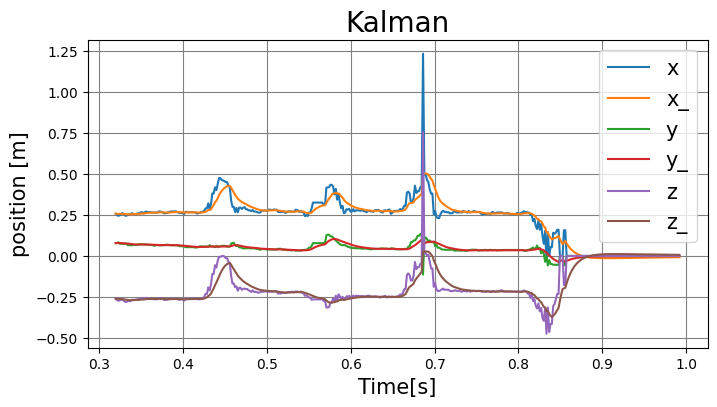

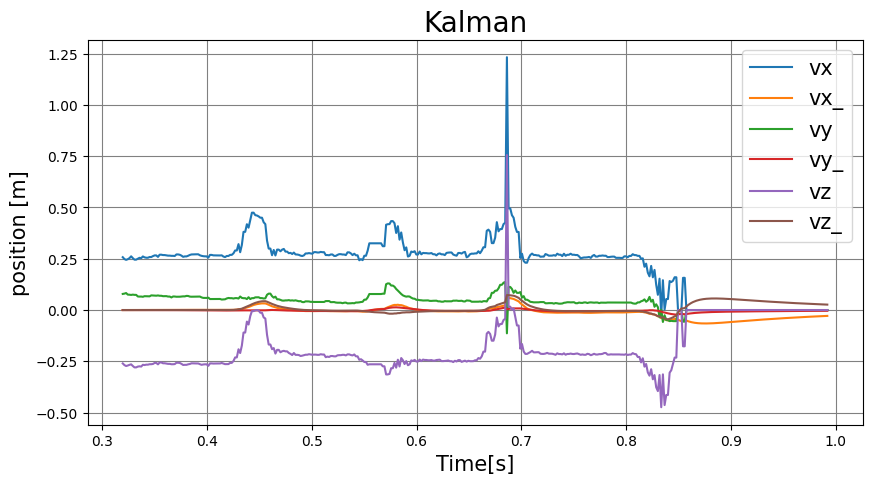

In [32]:
x_ = kalmanX
vx_ = kalmanvX
y_ = kalmanY
vy_ = kalmanvY
z_ = kalmanZ
vz_ = kalmanvZ

w, h = 8, 4    
plt.figure(figsize=(w, h))
plt.plot(t, px, label="x")
plt.plot(t, x_, label="x_")
plt.plot(t, py, label="y")
plt.plot(t, y_, label="y_")
plt.plot(t, pz, label="z")
plt.plot(t, z_, label="z_")
plt.grid(color="grey")
plt.title("Kalman", fontsize=20)
plt.xlabel("Time[s]", fontsize=15)
plt.ylabel("position [m]", fontsize=15)
plt.legend(loc="best", fontsize=15)
plt.savefig("kalmanP.svg")

w, h = 10, 5    
plt.figure(figsize=(w, h))
plt.plot(t, vx, label="vx")
plt.plot(t, vx_, label="vx_")
plt.plot(t, vy, label="vy")
plt.plot(t, vy_, label="vy_")
plt.plot(t, vz, label="vz")
plt.plot(t, vz_, label="vz_")
plt.grid(color="grey")
plt.title("Kalman", fontsize=20)
plt.xlabel("Time[s]", fontsize=15)
plt.ylabel("position [m]", fontsize=15)
plt.legend(loc="best", fontsize=15)



In [13]:
print(axs)

NameError: name 'axs' is not defined

In [268]:
numMeas = len(px)
print("Num meas is: {}".format(numMeas))
kalmanX, kalmanY, kalmanZ = [], [], []
kalmanvX, kalmanvY, kalmanvZ = [], [], []
x_start = median_px[0]
vx_start = 0
y_start = median_py[0]
vy_start = 0
z_start = median_pz[0]
vz_start = 0

f = KalmanFilter (dim_x=6, dim_z=3)

# position vector
f.x = np.array([[x_start],
                [vx_start], 
                [y_start], 
                [vy_start], 
                [z_start], 
                [vz_start]])

# State transition 
f.F = np.array([[1., 0.04, 0., 0.00, 0., 0.00], 
                [0., 1.00, 0., 0.00, 0., 0.00], 
                [0., 0.00, 1., 0.04, 0., 0.00], 
                [0., 0.00, 0., 1.00, 0., 0.00], 
                [0., 0.00, 0., 0.00, 1., 0.04],
                [0., 0.00, 0., 0.00, 0., 1.00]])

f.P = np.array([[1., 0., 0., 0., 0., 0.], 
                [0., 1., 0., 0., 0., 0.], 
                [0., 0., 1., 0., 0., 0.], 
                [0., 0., 0., 1., 0., 0.], 
                [0., 0., 0., 0., 1., 0.],
                [0., 0., 0., 0., 0., 1.]])

f.R = np.eye(3)*50
f.H = np.array([[1., 0., 0., 0., 0., 0.], 
                [0., 0., 1., 0., 0., 0.], 
                [0., 0., 0., 0., 1., 0.]])

f.Q = np.array([[5., 0., 0., 0., 0., 0.], 
                [0., 0.5, 0., 0., 0., 0.], 
                [0., 0., 5., 0., 0., 0.], 
                [0., 0., 0., 0.5, 0., 0.], 
                [0., 0., 0., 0., 5.0, 0.], 
                [0, 0., 0., 0., 0., 0.5]])




for i in range(0, numMeas):
    xn = getNextMeas(median_px, i)
    yn = getNextMeas(median_py, i)
    zn = getNextMeas(median_pz, i)
    f.predict()
    f.update(np.array([xn, yn, zn]))
    kalmanX.append(f.x[0])
    kalmanvX.append(f.x[1])
    kalmanY.append(f.x[2])
    kalmanvY.append(f.x[3])
    kalmanZ.append(f.x[4])
    kalmanvZ.append(f.x[5])

Num meas is: 9754


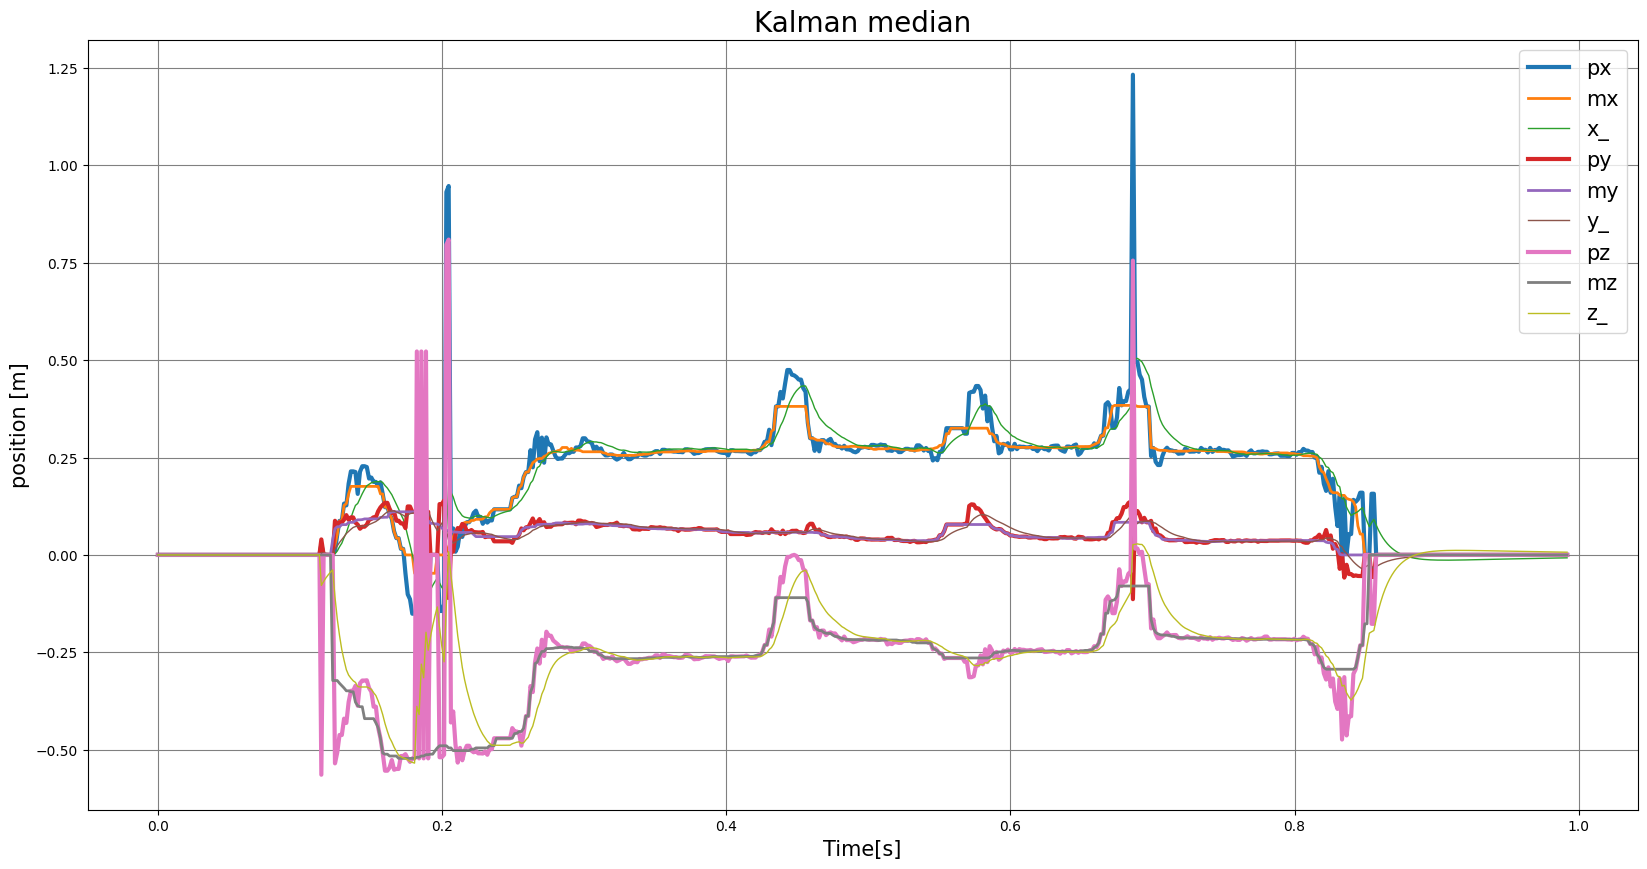

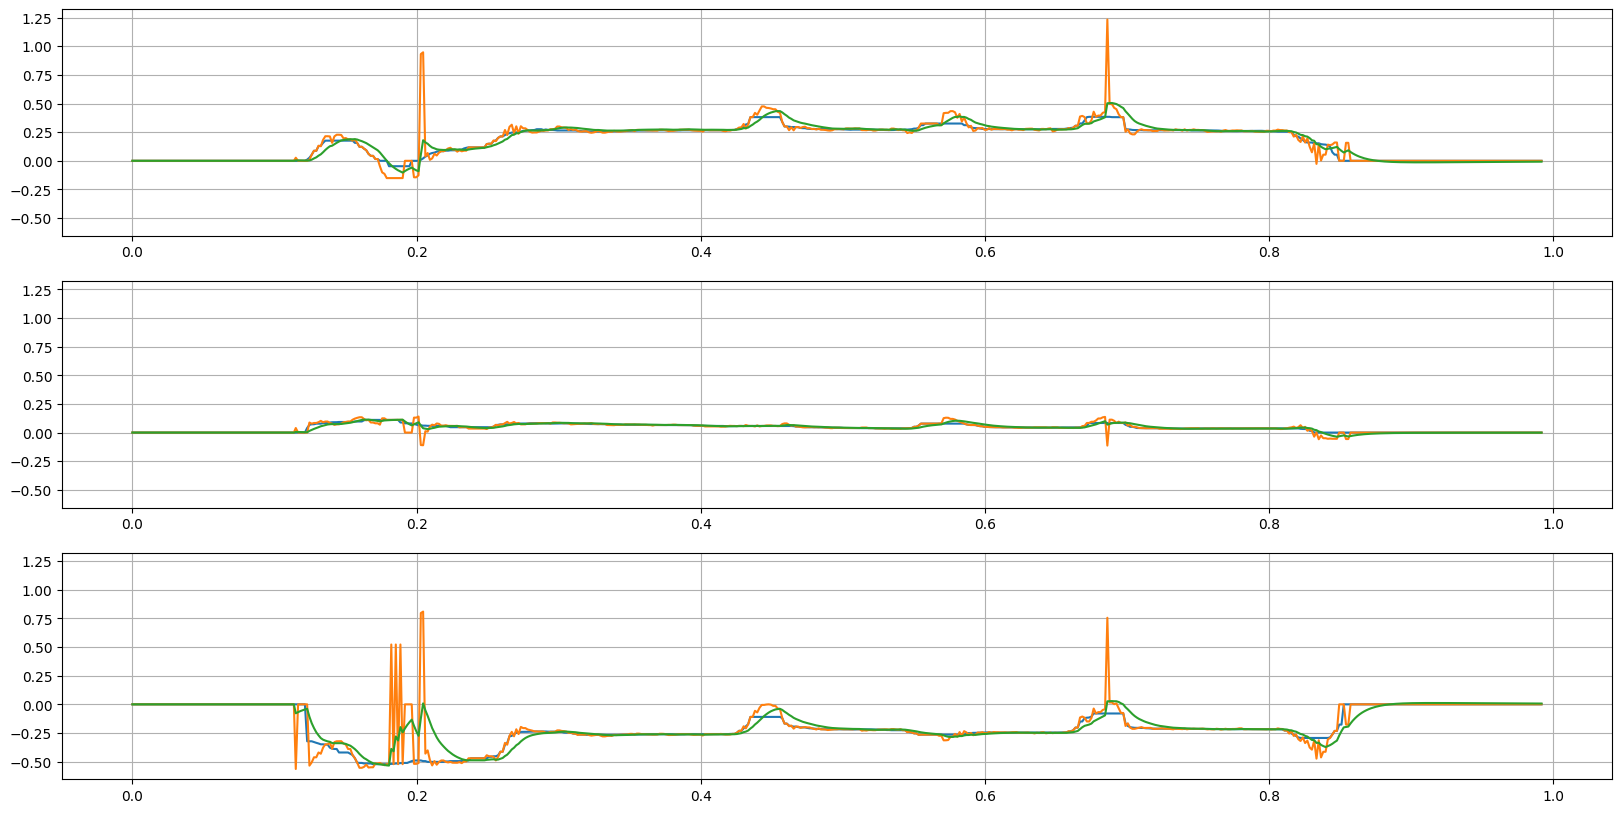

In [14]:
x_ = kalmanX
vx_ = kalmanvX
y_ = kalmanY
vy_ = kalmanvY
z_ = kalmanZ
vz_ = kalmanvZ

w, h = 20, 10    
plt.figure(figsize=(w, h))
l_ = 3
ml_ = 2
kl_ = 1
plt.plot(t, px, label="px", linewidth=l_)
plt.plot(t, median_px, label="mx", linewidth=ml_)
plt.plot(t, x_, label="x_", linewidth=kl_)
plt.plot(t, py, label="py", linewidth=l_)
plt.plot(t, median_py, label="my", linewidth=ml_)
plt.plot(t, y_, label="y_", linewidth=kl_)
plt.plot(t, pz, label="pz", linewidth=l_)
plt.plot(t, median_pz, label="mz", linewidth=ml_)
plt.plot(t, z_, label="z_", linewidth=kl_)
plt.grid(color="grey")
plt.title("Kalman median", fontsize=20)
plt.xlabel("Time[s]", fontsize=15)
plt.ylabel("position [m]", fontsize=15)
plt.legend(loc="best", fontsize=15)


f, axs = plt.subplots(3, 1, sharey=True, figsize=(20, 10))
axs[0].plot(t, median_px, label="mx")
axs[0].plot(t, px, label="px")
axs[0].plot(t, x_, label="x_")
#axs[0].set_ylim(np.min(px), np.max(px))
axs[0].grid()
axs[1].plot(t, median_py, label="my")
axs[1].plot(t, py, label="y")
axs[1].plot(t, y_, label="y_")
#axs[1].set_ylim(np.min(py), np.max(py))
axs[1].grid()
axs[2].plot(t, median_pz, label="my")
axs[2].plot(t, pz, label="z")
axs[2].plot(t, z_, label="z_")
#axs[2].set_ylim(np.min(pz), np.max(pz))
axs[2].grid()

In [1]:
import scipy
import bagpy
import numpy as np
from bagpy import bagreader
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
from matplotlib import rc
import statistics
rc('text', usetex=False) 


/home/zozan/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
bag = "recorded_data.bag"
b = bagreader(bag)
csv_files = get_topics(b)
joint_states = pd.read_csv(csv_files[0])
joint_trajectory = pd.read_csv(csv_files[1])
print(csv_files)

[INFO]  Data folder recorded_data already exists. Not creating.
['recorded_data/joint_states.csv', 'recorded_data/position_joint_trajectory_controller-command.csv']


In [72]:


def parse_timeseries_string(string_data):
    # Define regular expressions for extracting positions and velocities
    positions_pattern = re.compile(r'positions: \[([^\]]+)\]')
    velocities_pattern = re.compile(r'velocities: \[([^\]]+)\]')
    time_pattern = re.compile(r'time_from_start: \n\s*secs: (\d+)\n\s*nsecs: (\d+)')

    # Extract data using regular expressions
    positions_match = positions_pattern.findall(string_data)
    velocities_match = velocities_pattern.findall(string_data)
    time_match = time_pattern.findall(string_data)

    # Initialize lists for positions and velocities
    positions_list = []
    velocities_list = []
    times_list = []

    # Extract positions
    for positions_str in positions_match:
        positions_list.append([float(pos) for pos in positions_str.split(',')])

    # Extract velocities (assuming an empty list if not found)
    for velocities_str in velocities_match:
        velocities_list.append([float(vel) for vel in velocities_str.split(',')])
        
    # Extract time_from_start
    for secs, nsecs in time_match:
        time_in_seconds = int(secs) + int(nsecs) / 1e9
        times_list.append(time_in_seconds)

    return positions_list, velocities_list, times_list


In [16]:
print(joint_trajectory['points'][0])
print(joint_trajectory['points'][1])
print(joint_trajectory['points'][2])

print(type(joint_trajectory['points']))

[positions: [0.5828012257520144, -0.7163942455249127, -0.7322193504709068, -2.13192242861614, -0.984580967964023]
velocities: []
accelerations: []
effort: []
time_from_start: 
  secs: 0
  nsecs:         0, positions: [-0.488, -0.641, 0.553, -2.17, -0.525, 3.19, 0.05]
velocities: []
accelerations: []
effort: []
time_from_start: 
  secs: 5
  nsecs:         0]
[positions: [-0.4698678145974028, -0.6436397111510622, 0.5314973570465163, -2.170197582661277, -0.5267800055579106, 3.1899445446464, 0.03818524250759591]
velocities: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
accelerations: []
effort: []
time_from_start: 
  secs: 4
  nsecs: 174294006, positions: [-0.26134219102974543, -0.5933104012523839, 0.22710533545169448, -2.24384809115726, -0.5623327055428113, 3.2700038946389927, -0.11174452496811678]
velocities: [0.20778787513403693, 0.027108147266089896, -0.2770357165218796, -0.027697814966623907, -0.04935385972600466, 0.03624465093195658, -0.10899767568105115]
accelerations: []
effort: []
time_from

In [17]:
def parse_timeseries(timeseries):
    positions_list = []
    times_list = []

    for entry in timeseries:
        positions = entry.get('positions', [])
        time_from_start = entry.get('time_from_start', {})
        secs = time_from_start.get('secs', 0)
        nsecs = time_from_start.get('nsecs', 0)
        time_in_seconds = secs + nsecs / 1e9  # Convert nanoseconds to seconds

        positions_list.append(positions)
        times_list.append(time_in_seconds)

    return positions_list, times_list

In [18]:
positions, times = parse_timeseries(joint_trajectory['points'][0])

AttributeError: 'str' object has no attribute 'get'

In [45]:
import re




In [42]:
import matplotlib.pyplot as plt

def plot_joint_positions_velocities(positions, velocities, times):
    # Plot Joint Positions
    plt.figure(figsize=(12, 6))
    for i in range(len(positions[0])):
        plt.plot(times, [pos[i] for pos in positions], label=f'Joint {i+1} Position')

    plt.title('Joint Positions Over Time')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Joint Positions')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Joint Velocities
    plt.figure(figsize=(12, 6))
    for i in range(len(velocities[0])):
        plt.plot(times, [vel[i] for vel in velocities], label=f'Joint {i+1} Velocity')

    plt.title('Joint Velocities Over Time')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Joint Velocities')
    plt.legend()
    plt.grid(True)
    plt.show()

In [25]:
parse_string(joint_trajectory['points'][0])

([0.5828012257520144,
  -0.7163942455249127,
  -0.7322193504709068,
  -2.13192242861614,
  -0.984580967964023],
 [])

In [26]:
print(joint_trajectory['points'][0])

[positions: [0.5828012257520144, -0.7163942455249127, -0.7322193504709068, -2.13192242861614, -0.984580967964023]
velocities: []
accelerations: []
effort: []
time_from_start: 
  secs: 0
  nsecs:         0, positions: [-0.488, -0.641, 0.553, -2.17, -0.525, 3.19, 0.05]
velocities: []
accelerations: []
effort: []
time_from_start: 
  secs: 5
  nsecs:         0]


In [101]:
# Commanded points for HoCook 
p_, v_, t = parse_timeseries_string(joint_trajectory['points'][1])
q0 = [p[0] for p in p_]; v0 = [v[0] for v in v_]
q1 = [p[1] for p in p_]; v1 = [v[1] for v in v_]
q2 = [p[2] for p in p_]; v2 = [v[2] for v in v_]
q3 = [p[3] for p in p_]; v3 = [v[3] for v in v_]
q4 = [p[4] for p in p_]; v4 = [v[4] for v in v_]
q5 = [p[5] for p in p_]; v5 = [v[5] for v in v_]
q6 = [p[6] for p in p_]; v6 = [v[6] for v in v_]
t.insert(0, 0)

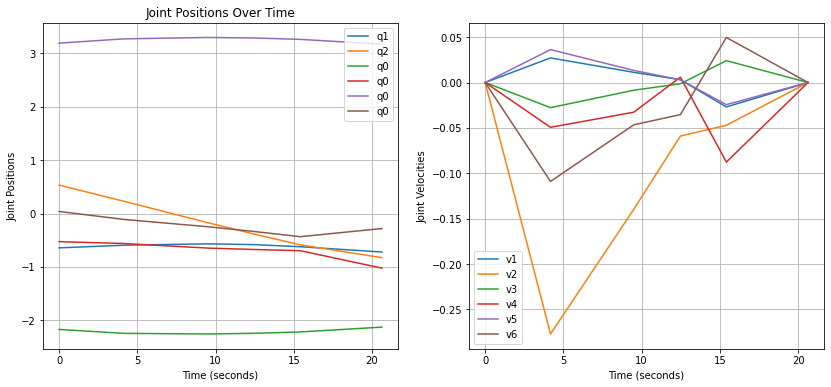

In [102]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columnsplt.plot(t, q0, label="q0"); plt.plot(t, v0, label="v0")
axs[0].plot(t, q1, label="q1"); axs[1].plot(t, v1, label="v1"); 
axs[0].plot(t, q2, label="q2"); axs[1].plot(t, v2, label="v2")
axs[0].plot(t, q3, label="q0"); axs[1].plot(t, v3, label="v3")
axs[0].plot(t, q4, label="q0"); axs[1].plot(t, v4, label="v4")
axs[0].plot(t, q5, label="q0"); axs[1].plot(t, v5, label="v5")
axs[0].plot(t, q6, label="q0"), axs[1].plot(t, v6, label="v6")
axs[0].set_title('Joint Positions Over Time')
axs[0].grid(True); axs[1].grid(True)
axs[0].legend(), axs[1].legend()
axs[0].set_xlabel('Time (seconds)'); axs[1].set_xlabel('Time (seconds)')
axs[0].set_ylabel('Joint Positions'); axs[1].set_ylabel('Joint Velocities')
plt.show()

In [103]:
def parse_joint_states(joint_states): 
    
    n_joints = len(joint_states["name"][0].split(","))
    q = {}
    q["t"] = joint_states["Time"]
    print(n_joints)
    for i in range(0, n_joints): 
        q["p{}".format(i)] = joint_states["position_{}".format(i)]
        q["v{}".format(i)] = joint_states["velocity_{}".format(i)]
    return q
q = parse_joint_states(joint_states)

9


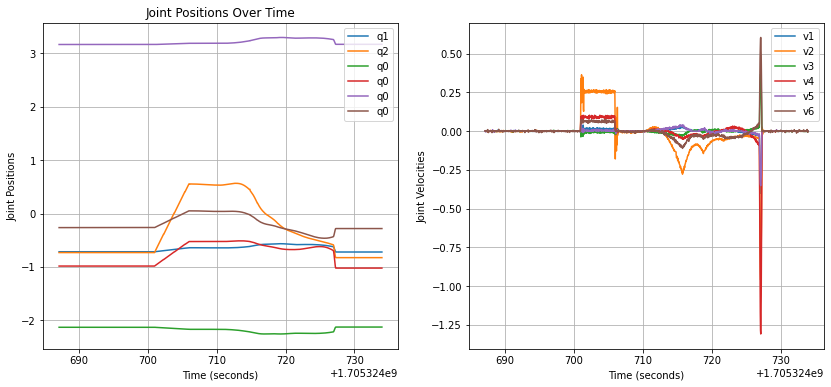

In [105]:
t = q["t"]
q0 = q["p0"]; v0 = q["v0"]
q1 = q["p1"]; v1 = q["v1"]
q2 = q["p2"]; v2 = q["v2"]
q3 = q["p3"]; v3 = q["v3"]
q4 = q["p4"]; v4 = q["v4"]
q5 = q["p5"]; v5 = q["v5"]
q6 = q["p6"]; v6 = q["v6"]

fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columnsplt.plot(t, q0, label="q0"); plt.plot(t, v0, label="v0")
axs[0].plot(t, q1, label="q1"); axs[1].plot(t, v1, label="v1"); 
axs[0].plot(t, q2, label="q2"); axs[1].plot(t, v2, label="v2")
axs[0].plot(t, q3, label="q0"); axs[1].plot(t, v3, label="v3")
axs[0].plot(t, q4, label="q0"); axs[1].plot(t, v4, label="v4")
axs[0].plot(t, q5, label="q0"); axs[1].plot(t, v5, label="v5")
axs[0].plot(t, q6, label="q0"), axs[1].plot(t, v6, label="v6")
axs[0].set_title('Joint Positions Over Time')
axs[0].grid(True); axs[1].grid(True)
axs[0].legend(), axs[1].legend()
axs[0].set_xlabel('Time (seconds)'); axs[1].set_xlabel('Time (seconds)')
axs[0].set_ylabel('Joint Positions'); axs[1].set_ylabel('Joint Velocities')
plt.show()

In [21]:
import csv

def read_file(file_path):
    a_ = []
    with open(file_path, 'r') as file:
        for row in file:
            a = [float(i) for i in row.split(",")]
            a_.append(a)
    return a_
            

# Example usage:
file_path = 'your_file.txt'

# Example usage:
csv_file_path = '/home/zozan/Work/FER/ros_utils/bags/lab0_hocook_Q.txt'  # Replace with the path to your CSV file
a = read_file(csv_file_path)

print(a)

[[-0.48807, -0.64125, 0.5531, -2.1703, -0.52509, 3.1901, 0.049987], [-0.48806, -0.64125, 0.55309, -2.1703, -0.52509, 3.1901, 0.049982], [-0.48801, -0.64124, 0.55302, -2.1704, -0.52509, 3.1901, 0.049946], [-0.48789, -0.64121, 0.55283, -2.1704, -0.52511, 3.1902, 0.04985], [-0.48764, -0.64114, 0.55247, -2.1705, -0.52515, 3.1903, 0.049667], [-0.48724, -0.64104, 0.55189, -2.1707, -0.52522, 3.1904, 0.049372], [-0.48666, -0.64089, 0.55103, -2.1709, -0.52531, 3.1907, 0.04894], [-0.48587, -0.64069, 0.54987, -2.1712, -0.52543, 3.191, 0.04835], [-0.48484, -0.64043, 0.54835, -2.1716, -0.5256, 3.1914, 0.047582], [-0.48354, -0.6401, 0.54645, -2.1721, -0.5258, 3.1919, 0.046618], [-0.48196, -0.63969, 0.54412, -2.1727, -0.52605, 3.1926, 0.045441], [-0.48006, -0.63921, 0.54134, -2.1734, -0.52635, 3.1933, 0.044036], [-0.47784, -0.63865, 0.53809, -2.1743, -0.52671, 3.1942, 0.042392], [-0.47528, -0.638, 0.53433, -2.1752, -0.52712, 3.1952, 0.040495], [-0.47236, -0.63726, 0.53005, -2.1764, -0.52758, 3.1963, 

In [12]:
import os

def list_files_in_current_folder():
    current_folder = os.getcwd()  # Get the current working directory
    files = [f for f in os.listdir(current_folder) if os.path.isfile(os.path.join(current_folder, f))]
    

In [13]:
list_files_in_current_folder()